In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt
from probe_utils import *
from plot_utils import *
from tqdm import tqdm

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple
import os
from data import DataArgs, Dataset, iterate_batches, make_dataset
from ihead_full_model import *

%load_ext autoreload
%autoreload 2


In [2]:
fontsize = 18
dir_name = "~/figures/BBM_appendix/"

## More attention maps

In [3]:
torch.cuda.set_device(6)
device = 'cuda:6'
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/pre-iclr/dynamics/bbm_long_train_redo"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=1, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)

In [4]:
model_loader.change_steps(100000)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
oracle_risk = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
risk[1:3]

/data/tianyu/miniconda3/envs/nanogpt/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


(tensor(5.5004e-06, device='cuda:6', grad_fn=<MeanBackward0>),
 tensor(2.2299, device='cuda:6', grad_fn=<MeanBackward0>))

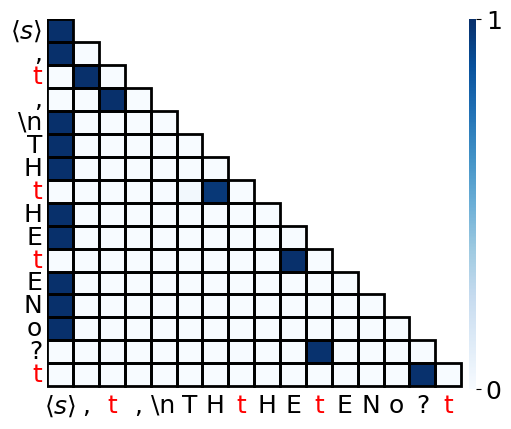

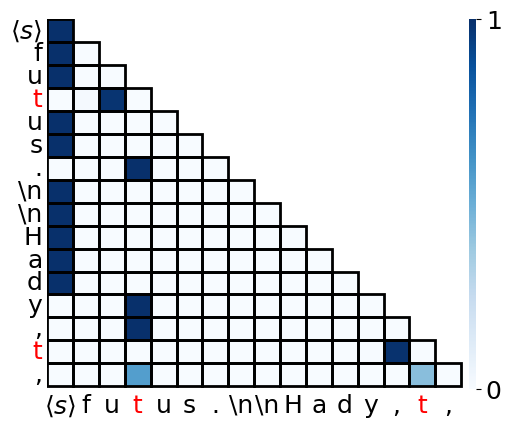

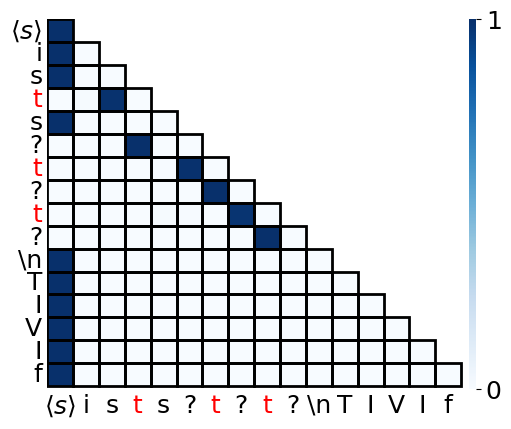

In [5]:
seq_indices = [0, 1, 2]
seq_len = 16
layer_idx = 0
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=["app_attn_fig1.pdf", "app_attn_fig2.pdf", "app_attn_fig3.pdf"], fn=dir_name, red_trigger=True, use_grid=True)

# 1-layer norm

  0%|          | 0/546 [00:00<?, ?it/s]

100%|██████████| 546/546 [00:38<00:00, 14.06it/s]


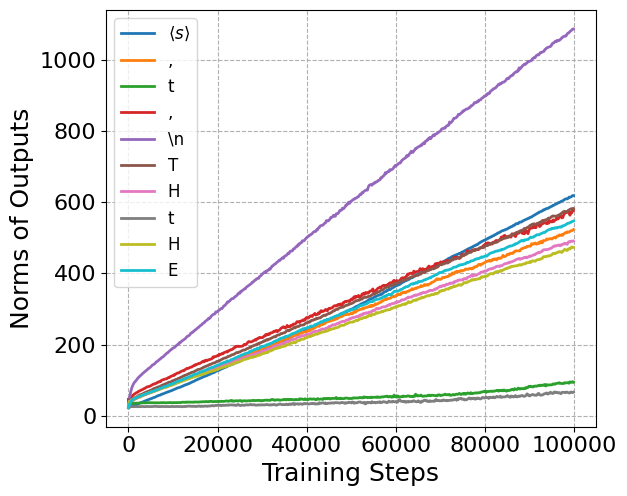

In [6]:
recompute = True
if recompute:
    unique_x = torch.unique(x)
    outputs_norms = {}
    logits = {}
    value_states_norm = {}
    icl_risks = {}
    markov_risks = {}
    attns_on_bos = {}
    bos_logit_differece_list = {}
    non_bos_logits_list = {}
    test_logits = {}

    with torch.no_grad():
        for step in tqdm(torch.arange(0, 1001, 20).tolist()+torch.arange(1000, 100000, 200).tolist()):
            model_loader.change_steps(step)
            model, _, optim = model_loader(with_data=False, state_name="attn_state" if step >= 100000 else None)
            pred, outputs_list = model.modified_forward_with_hook(x, hook)
            outputs_norms[step] = outputs_list[0]['output'][0, :10, :].norm(dim=-1)
    outputs_norms_summary = torch.stack(list(outputs_norms.values()), dim=0)
    torch.save(outputs_norms_summary, "~/figures/BBM/one_layer_dynamics.pt")
else:
    outputs_norms_summary = torch.load("~/figures/BBM/one_layer_dynamics.pt")

x_keys = torch.arange(0, 1000, 20).tolist()+torch.arange(1000, 100000, 200).tolist()
ds.update_decoder()
text = ds.decode(x[0, :].cpu().tolist())
text[0] = r'$\langle s \rangle$'

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
lw = 2
for i in range(10):
    ax.plot(x_keys, outputs_norms_summary[:, i].cpu().detach(), label=text[i], lw=lw)
ax.grid(linestyle='--')
ax.legend(fontsize=12)

plt.xlabel("Training Steps", fontsize=18)
plt.ylabel("Norms of Outputs", fontsize=18)
plt.tight_layout()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig(os.path.join(dir_name, "one_layer_dynamics.pdf"), bbox_inches='tight')

## 3 Layer Intervention Results

In [7]:
run_path_server = "~/gens/pre-iclr/dynamics/bbm_simplified"
layer_list = [2, 3, 3, 3, 3]
no_attn_list = [(), (), (2, ), (0, 2), (2, )]
no_ffn_list = [(), ( ), ( ), ( ), (0, )]
name_list = [r"$2\times$TF", r"$3\times$TF", r"$2\times$TF+MLP", "MLP+TF+MLP", "Attn+TF+MLP"]

massive_norms = {}
for layers, no_attn, no_ffn, name in zip(layer_list, no_attn_list, no_ffn_list, name_list):
    if name in ["$2\\times$TF", "$3\\times$TF"]:
        run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
    else:
        run_path_server = "~/gens/pre-iclr/dynamics/bbm_simplified"
    model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=layers, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=no_ffn, linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)
    model_loader.change_steps(10000)
    model, cfg, x, y, ds, optim = model_loader(with_data=True)
    idxs_in_torch = torch.Tensor(ds.idxs).to(device)
    triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
    hook = forward_hook([], '')
    pred, outputs_list = model.modified_forward_with_hook(x, hook)
    massive_norms[name] = outputs_list[0]['output'][0, 0, :].norm(dim=-1).item() - outputs_list[0]['output'][:, 1:, :].norm(dim=-1).mean().item()

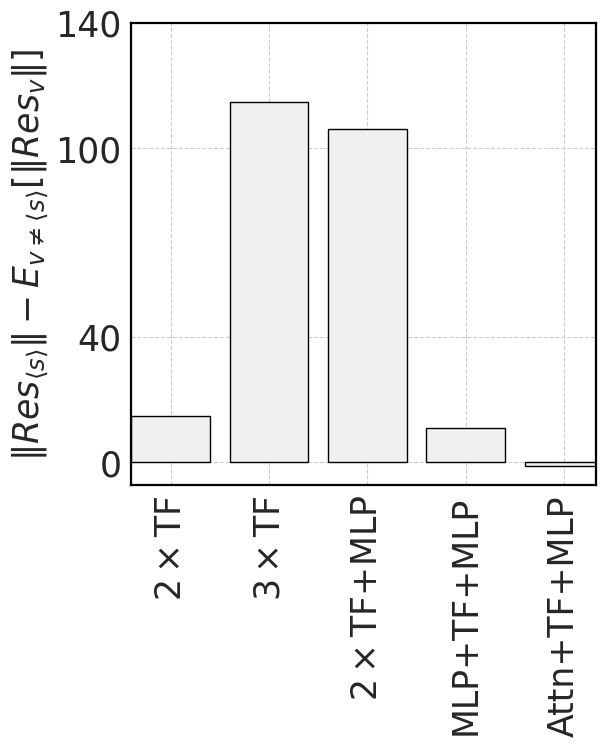

In [8]:
with sns.axes_style("whitegrid"):
    fontsize = 25
    fig, ax = plt.subplots(figsize=(6, 6))
    text = list(massive_norms.keys())
    norms = list(massive_norms.values())
    data = {'text': text, 'norm': norms}

    # Plot the bar plot with white facecolor and black edgecolor
    sns.barplot(x='text', y='norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black',)
    
    # Set the style and context
    sns.set_context("talk")

    # Set x and y ticks and labels
    ax.set_xticks(range(len(text)))
    ax.set_yticks([0, 40, 100, 140])
    ax.set_yticklabels([0, 40, 100, 140], fontsize=fontsize)
    # add x-tick labels
    ax.set_xticklabels(text, fontsize=fontsize)
    

    # Manually add rotated labels inside the plot
    # ax.set_xticklabels([])
    # for i, label in enumerate(text):
    #     ax.text(i, 45, label, ha='center', rotation=90, fontsize=18)

    # Set labels
    # ax.set_xlabel('different model structures', fontsize=fontsize)
    ax.set_xlabel('')
    ax.set_ylabel(r'$\|Res_{\langle s \rangle}\|-E_{v\neq \langle s \rangle}[\|Res_{v}\|]$', fontsize=fontsize)


    # Set gridline properties: black color and solid lines
    # ax.grid(linestyle='-', color='black')
    ax.grid(linestyle='--',)

    # Customize the spines to be solid, thin, black lines
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

    # Keep x-ticks non-rotated
    plt.xticks(rotation=90)
    plt.xlim(-0.4, len(text) - 0.67)

# fig, ax = plt.subplots(figsize=(10, 6))
# x_values = [0, 1, 2, 3, 4, 5, 6, 7, 8]
# x_labels = list(massive_norms.keys())
# x_labels = [x_labels[0], "", x_labels[1], "", x_labels[2], "", x_labels[3], "", x_labels[4]]
# y_values = list(massive_norms.values())
# y_values = [y_values[0], 0, y_values[1], 0, y_values[2], 0, y_values[3], 0, y_values[4]]

# ax.bar(x_values, y_values)
# ax.set_xticks(x_values)
# ax.set_xticklabels(x_labels, fontsize=fontsize)
# plt.gca().set_xticks([0, 1.5, 3, 4.5, 6])
# ax.margins(x=0.02)
# ax.bar(massive_norms.keys(), massive_norms.values())
# plt.xticks(fontsize=fontsize)
# plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(dir_name, "massive_norm_minimal.pdf"), bbox_inches='tight')
# plt.show()

## Attention maps, value states, and dynamics of multiple layer structures

In [9]:
torch.cuda.set_device(6)
device = 'cuda:6'
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/pre-iclr/dynamics/bbm_long_train_redo"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
oracle_risk = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
risk[1:3]

(tensor(5.0254e-05, device='cuda:6', grad_fn=<MeanBackward0>),
 tensor(2.2294, device='cuda:6', grad_fn=<MeanBackward0>))

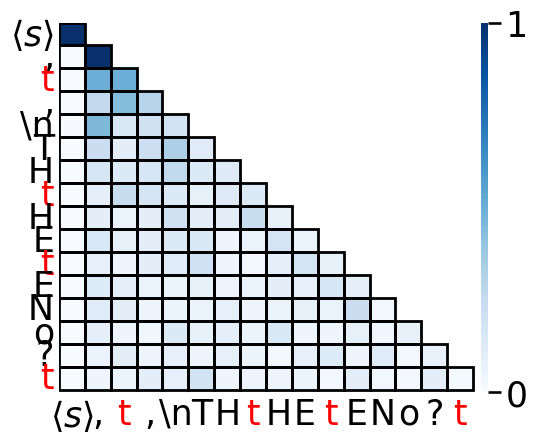

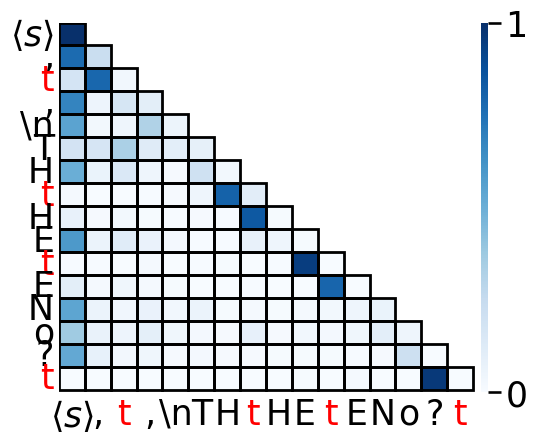

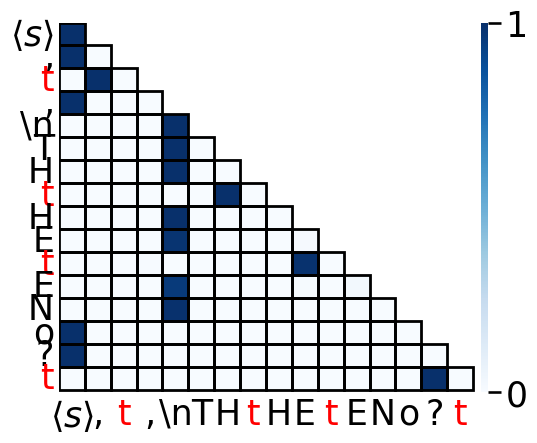

In [10]:
seq_indices = [0]
seq_len = 16
layer_idx = 0
head_idx = 0
for layer_idx in range(3):
    plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=[f'massive_attn_step10k_fig{layer_idx}.pdf'], fn=dir_name, red_trigger=True, use_grid=True)

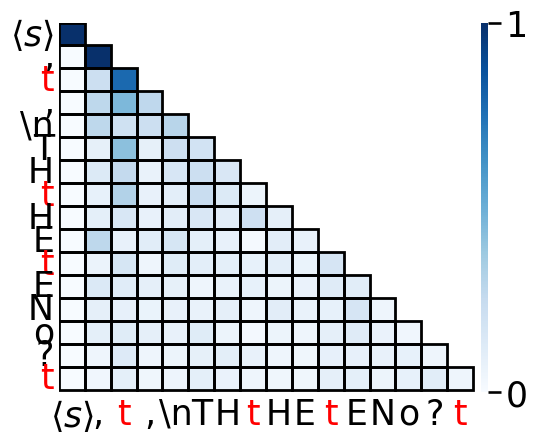

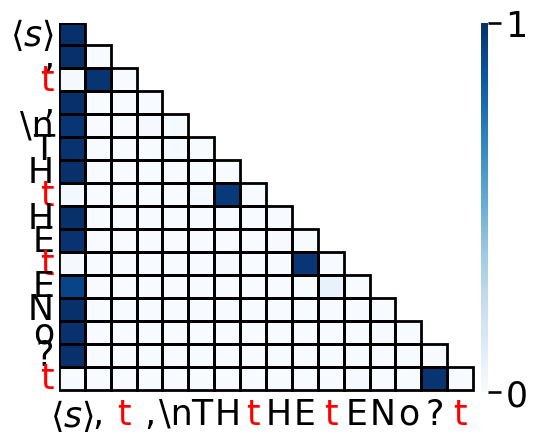

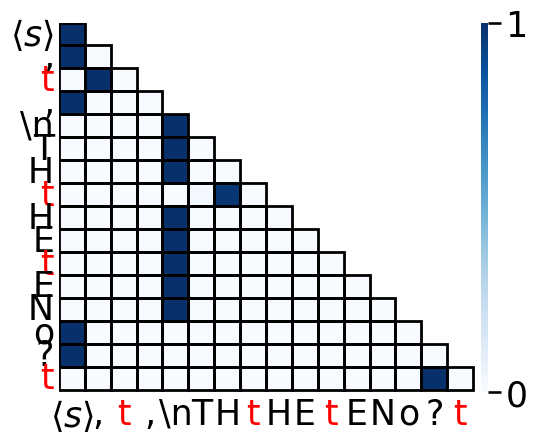

In [11]:
model_loader.change_steps(100000)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
oracle_risk = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
risk[1:3]
seq_indices = [0]
seq_len = 16
layer_idx = 0
head_idx = 0
for layer_idx in range(3):
    plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=[f'massive_attn_step_100k_fig{layer_idx}.pdf'], fn=dir_name, red_trigger=True, use_grid=True)

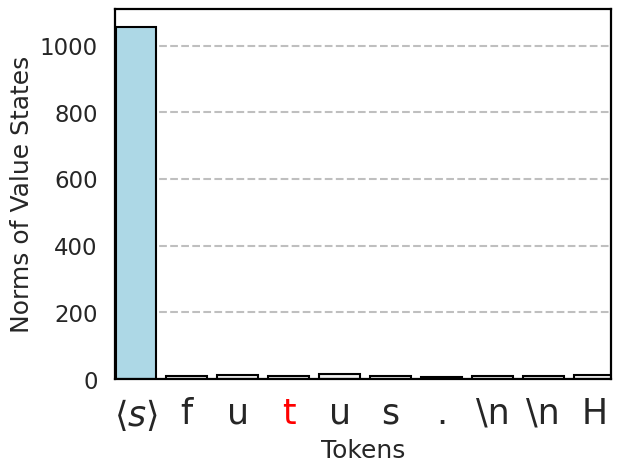

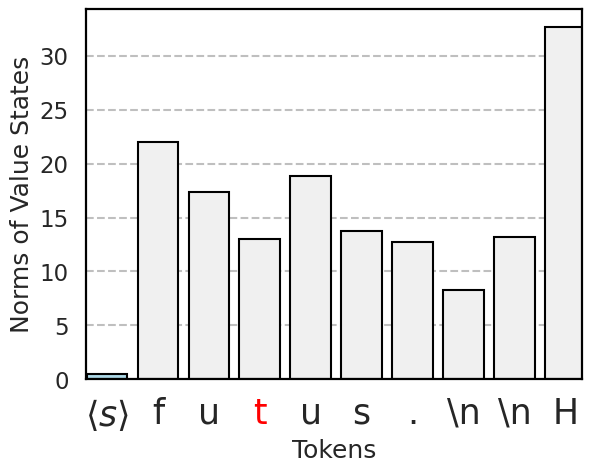

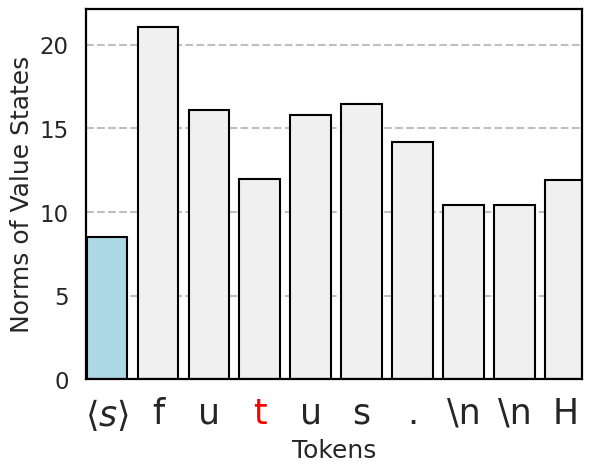

In [12]:
for layer_idx in range(3):
    idx = 1
    v_norm = model.layers[0].attention.wo(outputs_list[layer_idx]['value_states'][idx, 0, :10, :]).norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'$\langle s \rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Value States', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"value_states_layer_{layer_idx}.pdf"), bbox_inches='tight')

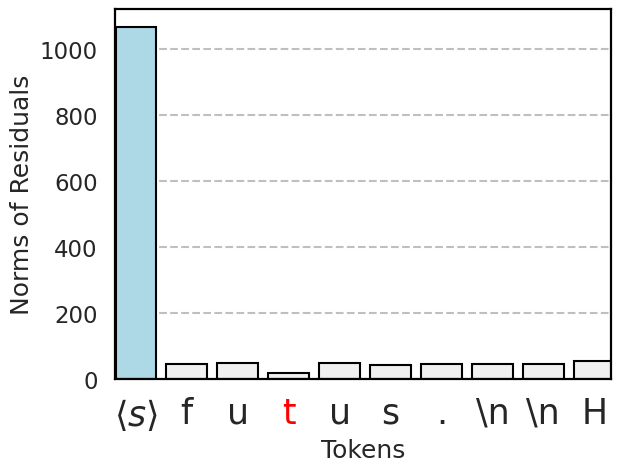

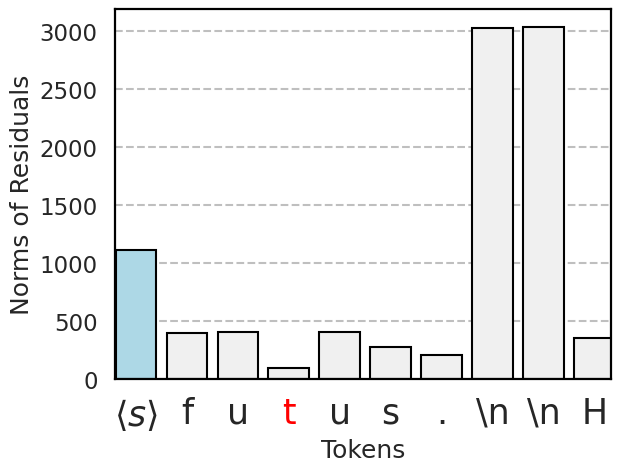

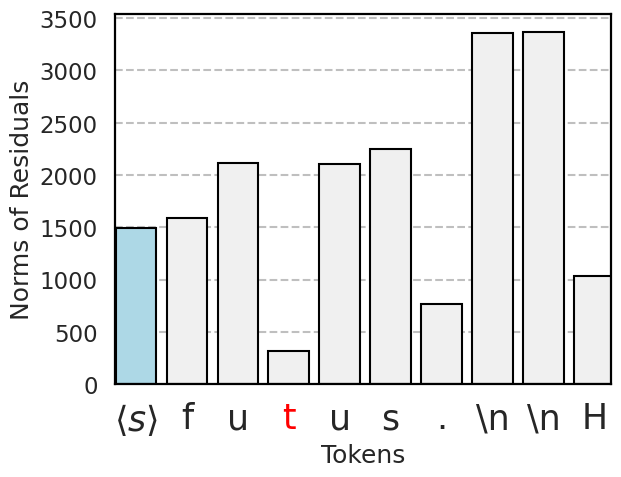

In [14]:
for layer_idx in range(3):
    idx = 1
    v_norm = outputs_list[layer_idx]['output'][idx, :10, :].norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'$\langle s \rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Residuals', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"norms_layer_{layer_idx}.pdf"), bbox_inches='tight')

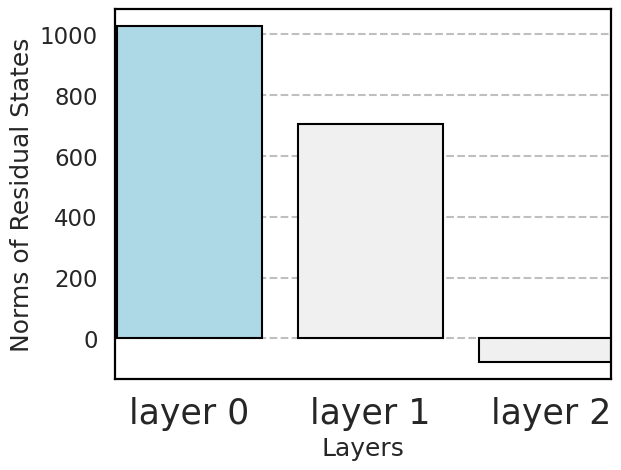

In [13]:
v_norm = [outputs_list[layer_idx]['output'][0, 0, :].norm(dim=-1).item() - outputs_list[layer_idx]['output'][:, 1:, :].norm(dim=-1).mean().item() for layer_idx in range(3)]
text = ['layer 0', 'layer 1', 'layer 2']

with sns.axes_style("whitegrid"):
    fontsize = 25
    fig, ax = plt.subplots()
    data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]*(len(text))}

    # Plot the bar plot with white facecolor and black edgecolor
    sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

    bars = ax.patches
    bars[0].set_facecolor("#add8e6")
    # Set the style and context
    sns.set_context("talk")

    # Set x and y ticks and labels
    ax.set_xticks(range(len(text)))
    ax.set_xticklabels(text, fontsize=fontsize)
    # if layer_idx in [1, 2]:
    #     ax.set_yticks([0, 5, 10, 15, 20])
    #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
    # else:
    #     ax.set_yticks([0, 10, 20, 30, 40])
    #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

    # Set labels
    ax.set_xlabel('Layers', fontsize=18)
    ax.set_ylabel('Norms of Residual States', fontsize=18)

    # Set gridline properties: black color and solid lines
    # ax.grid(linestyle='-', color='black')
    ax.grid(False, axis='y')

    # Customize the spines to be solid, thin, black lines
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

    # Keep x-ticks non-rotated
    plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
    plt.xticks(rotation=0)
    plt.xlim(-0.41, len(text) - 0.67)
    

    # Change the color of the x-tick label that equals 't' to red
    xticks = ax.get_xticklabels()
    for xt in xticks:
        if xt.get_text() == 't':
            xt.set_color('red')

    # Save the figure as a PDF
    plt.savefig(os.path.join(dir_name, f"Norms_L3.pdf"), bbox_inches='tight')

## Attention maps, value states, and massive norm of SGD

In [31]:
torch.cuda.set_device(6)
device = 'cuda:6'
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/pre-iclr/dynamics/bbm_sgd"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.03, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True, with_optim=False)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
oracle_risk = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
risk[1:3]

(tensor(0.0557, device='cuda:6', grad_fn=<MeanBackward0>),
 tensor(2.2300, device='cuda:6', grad_fn=<MeanBackward0>))

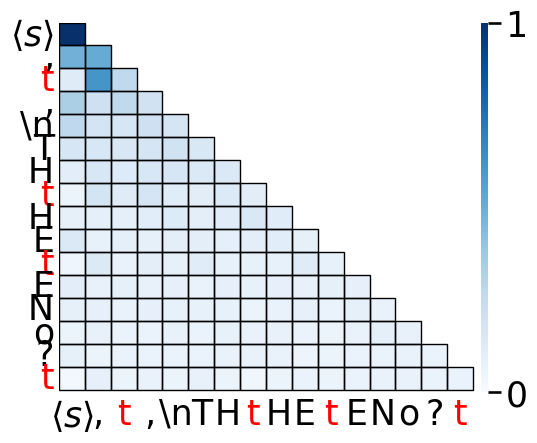

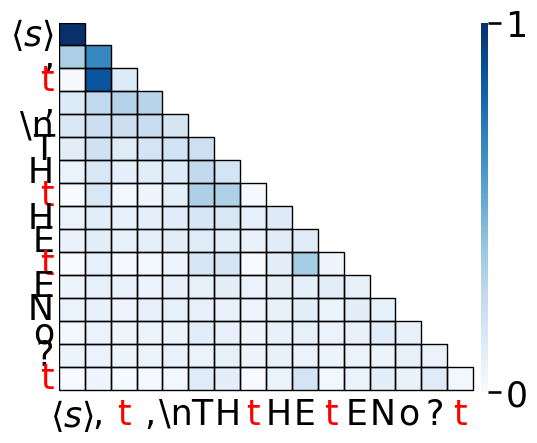

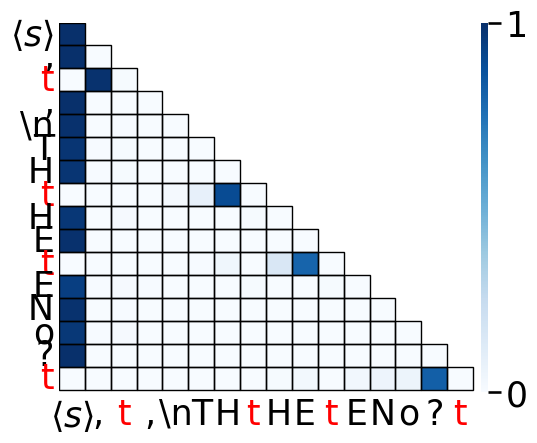

In [32]:
seq_indices = [0]
seq_len = 16
layer_idx = 0
head_idx = 0
for layer_idx in range(3):
    plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=[f'sgd_attn_step10k_fig{layer_idx}.pdf'], fn=dir_name, red_trigger=True, use_grid=True)

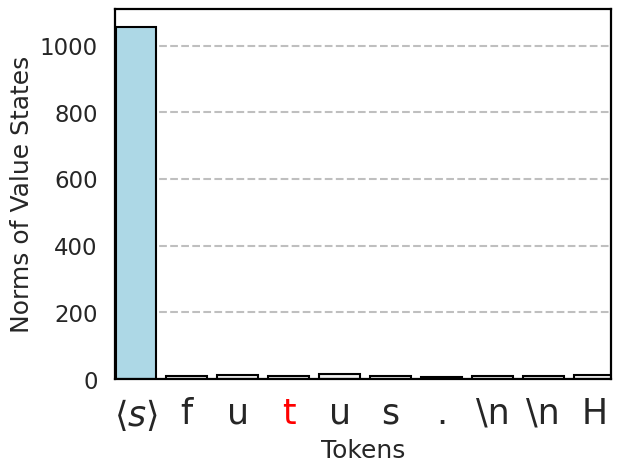

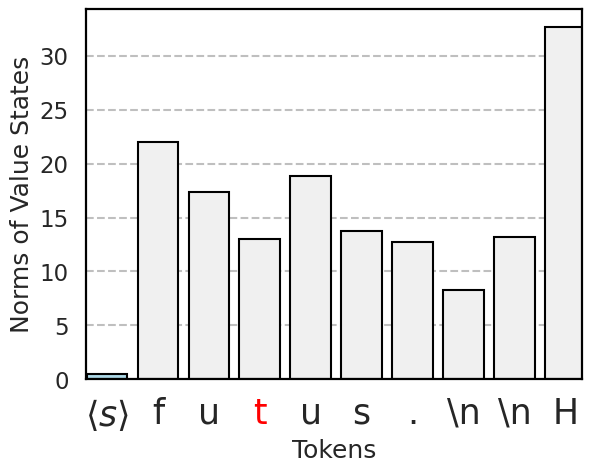

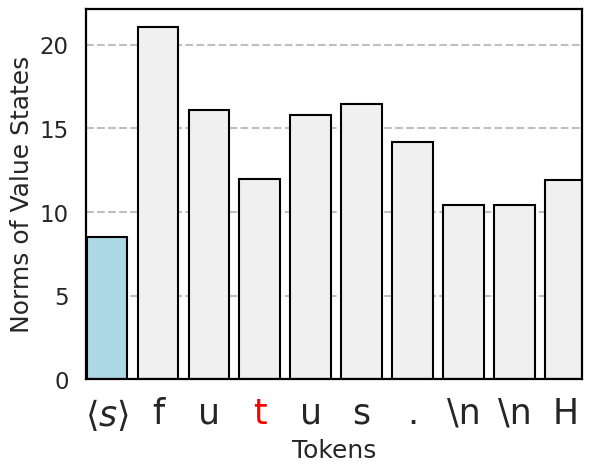

In [15]:
for layer_idx in range(3):
    idx = 1
    v_norm = model.layers[0].attention.wo(outputs_list[layer_idx]['value_states'][idx, 0, :10, :]).norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'$\langle s \rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Value States', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"sgd_value_states_layer_{layer_idx}.pdf"), bbox_inches='tight')

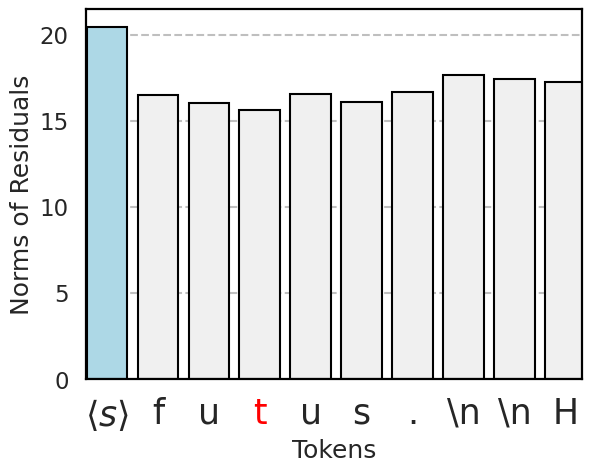

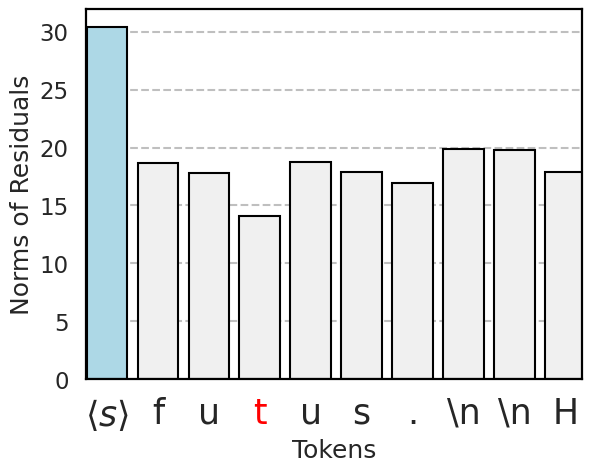

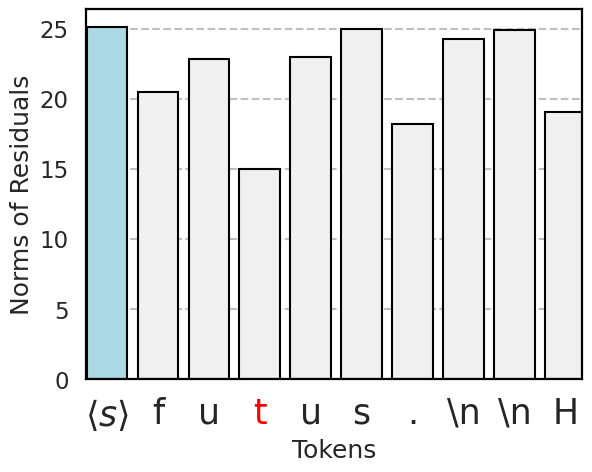

In [34]:
for layer_idx in range(3):
    idx = 1
    v_norm = outputs_list[layer_idx]['output'][idx, :10, :].norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'$\langle s \rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Residuals', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"sgd_norms_layer_{layer_idx}.pdf"), bbox_inches='tight')

## Attention maps, value states, and massive norm of ReLU attention

In [35]:
torch.cuda.set_device(6)
device = 'cuda:6'
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/pre-iclr/dynamics/ReLU_attn"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True, with_optim=False)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
oracle_risk = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
risk[1:3]

(tensor(3.4795e-05, device='cuda:6', grad_fn=<MeanBackward0>),
 tensor(2.2306, device='cuda:6', grad_fn=<MeanBackward0>))

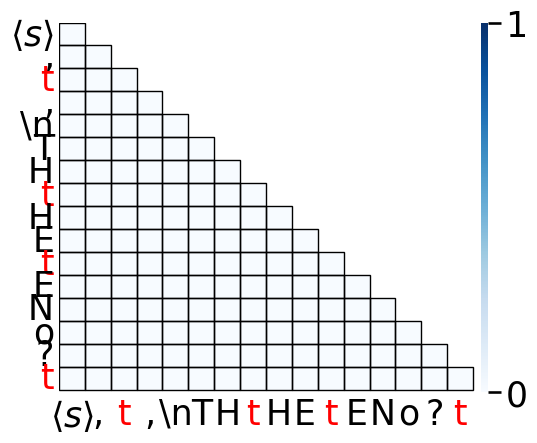

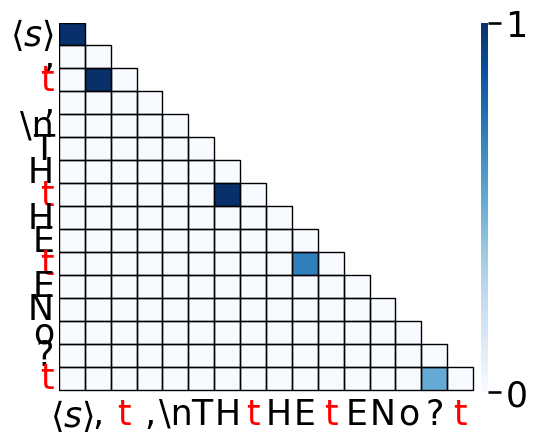

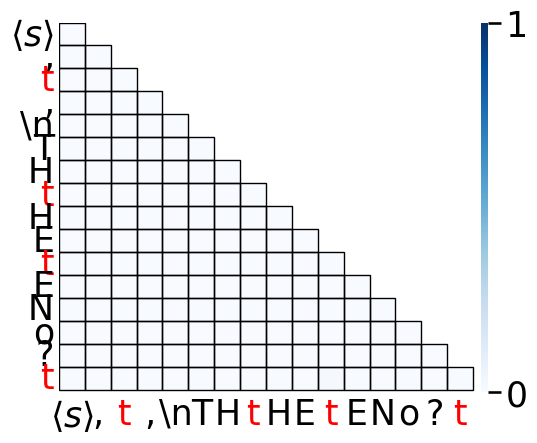

In [36]:
seq_indices = [0]
seq_len = 16
layer_idx = 0
head_idx = 0
for layer_idx in range(3):
    plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=[f'relu_attn_step10k_fig{layer_idx}.pdf'], fn=dir_name, red_trigger=True, use_grid=True)

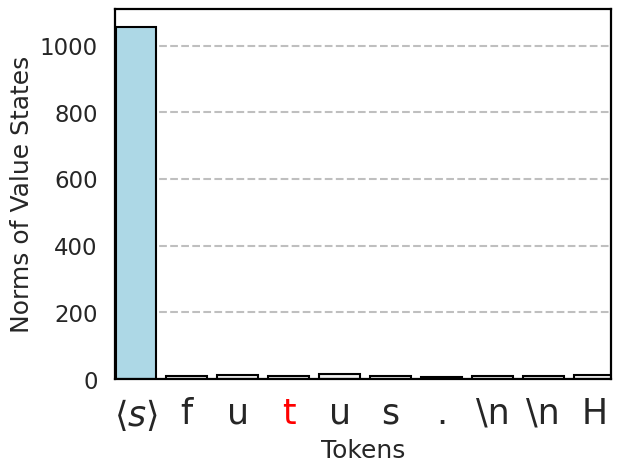

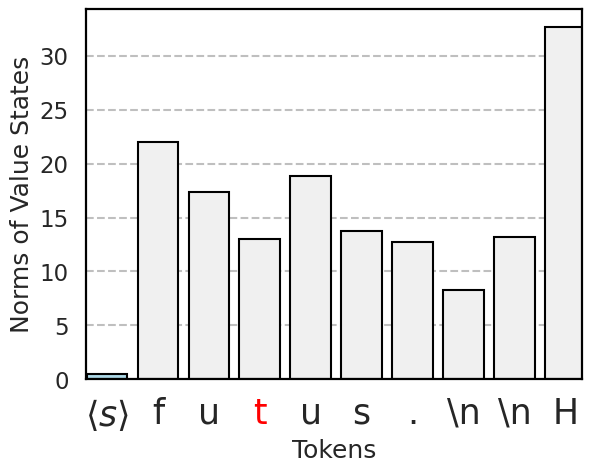

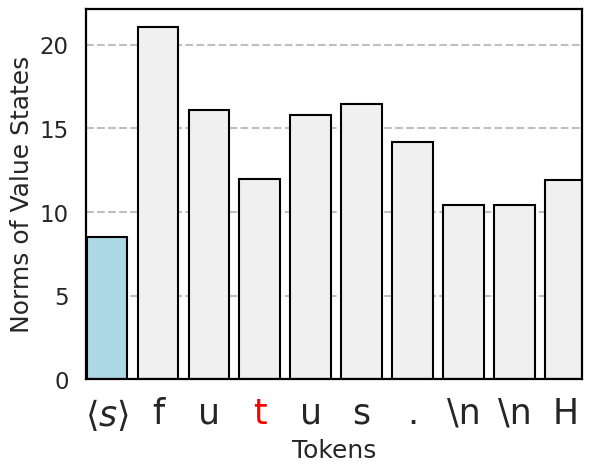

In [16]:
for layer_idx in range(3):
    idx = 1
    v_norm = model.layers[0].attention.wo(outputs_list[layer_idx]['value_states'][idx, 0, :10, :]).norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'$\langle s \rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Value States', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"relu_value_states_layer_{layer_idx}.pdf"), bbox_inches='tight')

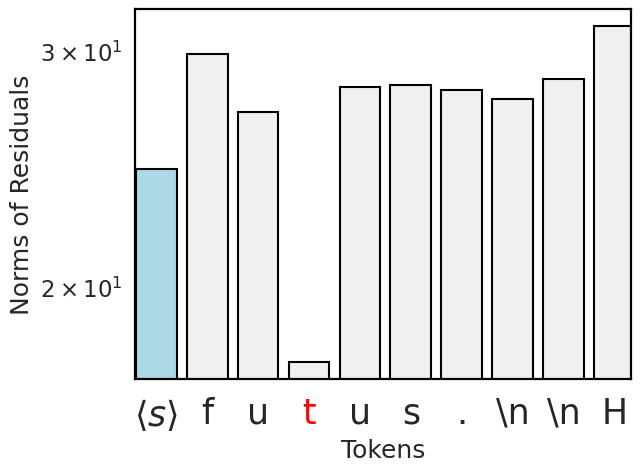

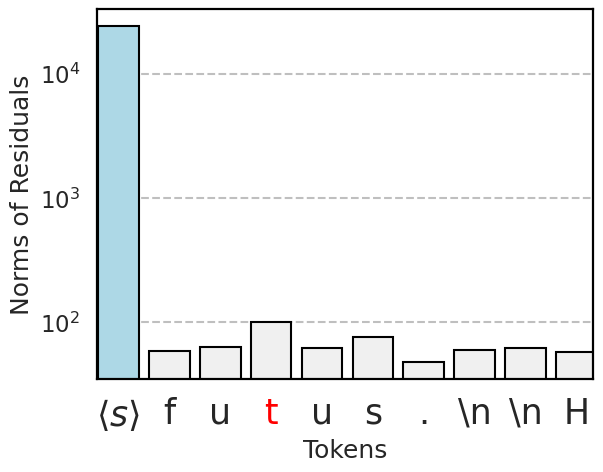

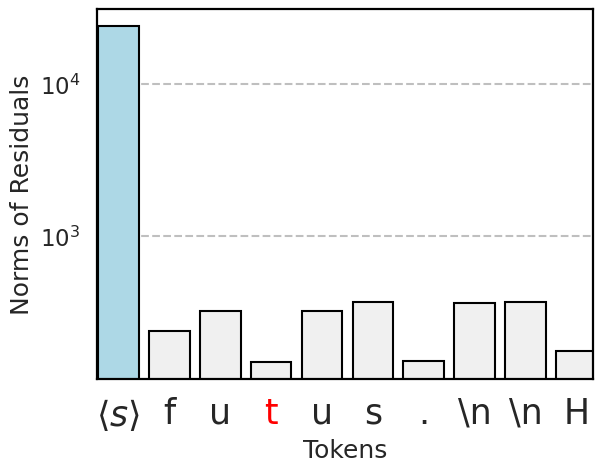

In [39]:
for layer_idx in range(3):
    idx = 1
    v_norm = outputs_list[layer_idx]['output'][idx, :10, :].norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'$\langle s \rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Residuals', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        ax.set_yscale('log')
        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"relu_norms_layer_{layer_idx}.pdf"), bbox_inches='tight')

## One layer ReLU

In [17]:
torch.cuda.set_device(6)
device = 'cuda:6'
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/pre-iclr/dynamics/ReLU_attn"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=1, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True, with_optim=False)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
oracle_risk = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
risk[1:3]

(tensor(3.9337e-06, device='cuda:6', grad_fn=<MeanBackward0>),
 tensor(2.2284, device='cuda:6', grad_fn=<MeanBackward0>))

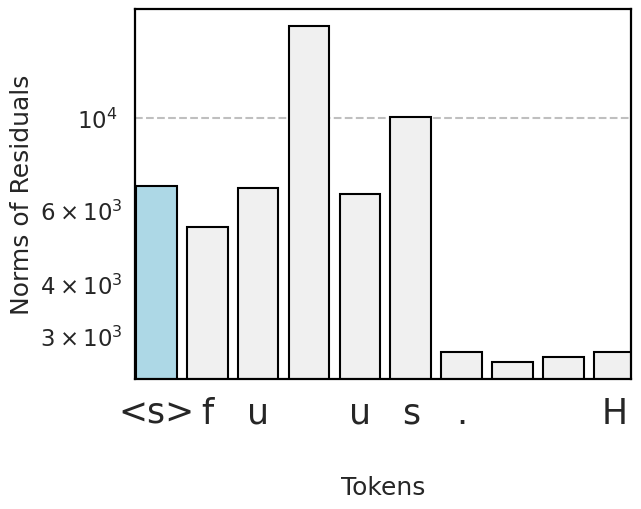

In [18]:
for layer_idx in range(1):
    idx = 1
    v_norm = outputs_list[layer_idx]['output'][idx, :10, :].norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'<s>'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Residuals', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        ax.set_yscale('log')
        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"relu1_norms.pdf"), bbox_inches='tight')

# ReLU dynamics

In [19]:
recompute = True
if recompute:
    unique_x = torch.unique(x)
    outputs_norms = {}
    logits = {}
    value_states_norm = {}
    icl_risks = {}
    markov_risks = {}
    attns_on_bos = {}
    bos_logit_differece_list = {}
    non_bos_logits_list = {}
    test_logits = {}

    with torch.no_grad():
        for step in tqdm(torch.arange(0, 1001, 20).tolist()+torch.arange(1000, 20000, 200).tolist()):
            model_loader.change_steps(step)
            model, _, optim = model_loader(with_data=False, state_name="attn_state" if step >= 100000 else None)
            pred, outputs_list = model.modified_forward_with_hook(x, hook)
            outputs_norms[step] = outputs_list[0]['output'][0, 0, :].norm(dim=-1).item()
            logits[step] = summarise_attns(outputs_list[0]['attn_logits'][:, 0, :, 0], x, unique_x)
            test_logits[step] = summarise_attns(outputs_list[0]['attn_logits'][:, 0, :, 0] - outputs_list[0]['attn_logits'][:, 0, :, 1], x, unique_x)
            non_bos_logits, bos_logit_differece = summarise_logits_difference(outputs_list[0]['attn_logits'][:, 0, ...], x, unique_x)
            bos_logit_differece_list[step] = bos_logit_differece
            non_bos_logits_list[step] = non_bos_logits
            attns_on_bos[step] = outputs_list[0]['attn_weights'][:, 0, :, 0][~triggers_pos].mean().detach().item()
            value_states_norm[step] = model.layers[0].attention.wo(outputs_list[0]['value_states'][0, 0, 0, :]).norm().item()
            risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
            icl_risks[step] = risk[1].item()
            markov_risks[step] = risk[2].item()
    logit_summary = torch.stack(list(logits.values()), dim=0)
    bos_logit_differece_summary = torch.stack(list(bos_logit_differece_list.values()), dim=0)
    non_bos_logits_summary = torch.stack(list(non_bos_logits_list.values()), dim=0)
    test_logits_summary = torch.stack(list(test_logits.values()), dim=0)
    torch.save((outputs_norms, logit_summary, value_states_norm, icl_risks, markov_risks, attns_on_bos, bos_logit_differece_summary, non_bos_logits_summary, test_logits_summary), "~/figures/BBM/ReLU_dynamics.pt")
else:
    outputs_norms, logit_summary, value_states_norm, icl_risks, markov_risks, attns_on_bos, bos_logit_differece_summary, non_bos_logits_summary, test_logits_summary = torch.load("~/figures/BBM/ReLU_dynamics.pt")

100%|██████████| 146/146 [00:20<00:00,  7.04it/s]


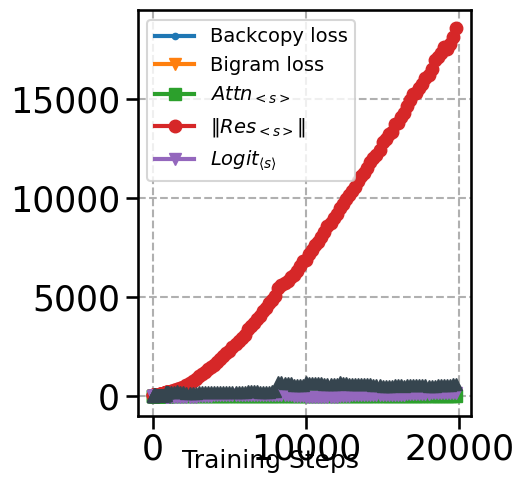

In [20]:
mask = np.isin(unique_x.cpu(), ds.idxs)
mask = ~mask
mask[-1] = False
mask
fontsize = 25
step_size = 1
x_keys = np.array(list(icl_risks.keys()))
stop_step = np.where(x_keys > 1000)[0].min()
x_keys = list(icl_risks.keys())[::step_size]

icl_y = np.array(list(icl_risks.values()))[::step_size]
markov_y = np.array(list(markov_risks.values()))[::step_size]
markov_y = markov_y - oracle_risk[2].item()

value_states_y = np.array(list(value_states_norm.values()))[::step_size]

outputs_norms_y = np.array(list(outputs_norms.values()))[::step_size]

attns_on_bos_y = np.array(list(attns_on_bos.values()))[::step_size]

logit_y = bos_logit_differece_summary[:, mask][::step_size].cpu()
logit_y_upper = logit_y.quantile(dim=1, q=0.9)
logit_y_lower = logit_y.quantile(dim=1, q=0.1)
logit_y = logit_y.mean(dim=1)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
lw = 3
ax.plot(x_keys, icl_y, label='Backcopy loss', marker='.', lw=lw)
ax.plot(x_keys, markov_y, label='Bigram loss', marker='v', lw=lw)
ax.plot(x_keys, attns_on_bos_y, label=r'$Attn_{<s>}$', marker='s', lw=lw)
ax.plot(x_keys, outputs_norms_y, label=r'$\|Res_{<s>}\|$', marker='o', lw=lw)
ax.plot(x_keys, logit_y, marker='v', label=r'$Logit_{\langle s\rangle}$', lw=lw)
ax.plot(x_keys, value_states_y, marker='^', color='#36454F', lw=lw)
ax.grid(linestyle='--')
fig.text(0.5, 0.03, 'Training Steps', ha='center', fontsize=18)
plt.tight_layout()
plt.legend(fontsize=14)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(dir_name, "ReLU_dynamics.pdf"), bbox_inches='tight')

## Attention maps, value states, and massive norm of no bos token

In [21]:
torch.cuda.set_device(6)
device = 'cuda:6'
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/final/bbm_k3_bos0"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=0, train_steps=10000, delim=0, n_layers=1, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True, with_optim=False)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
oracle_risk = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
risk[1:3]

(tensor(8.5618e-05, device='cuda:6', grad_fn=<MeanBackward0>),
 tensor(2.2154, device='cuda:6', grad_fn=<MeanBackward0>))

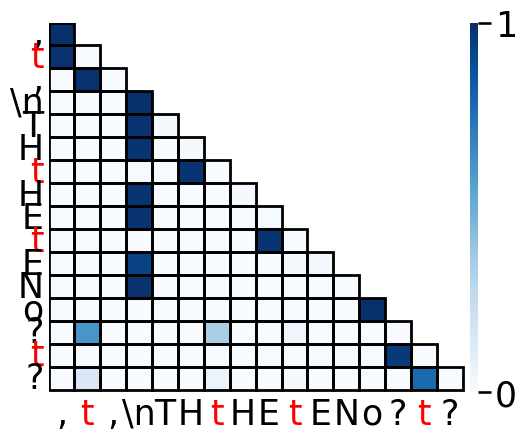

In [22]:
seq_indices = [0]
seq_len = 16
layer_idx = 0
head_idx = 0
plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=[f'no_bos_attn_fig{layer_idx}.pdf'], fn=dir_name, red_trigger=True, use_bos=False, use_grid=True)

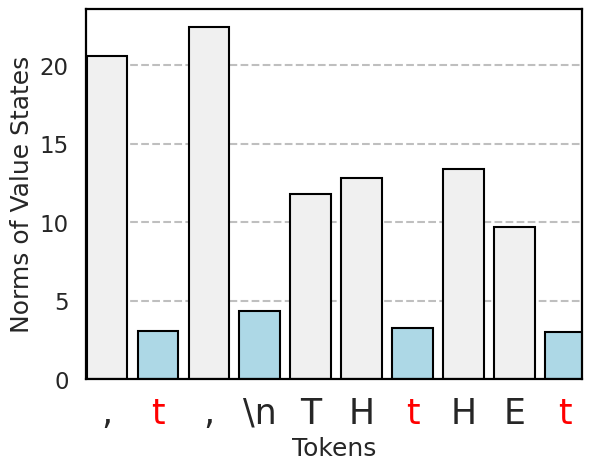

In [23]:
for layer_idx in range(1):
    idx = 0
    v_norm = model.layers[0].attention.wo(outputs_list[layer_idx]['value_states'][idx, 0, :10, :]).norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    # text[0] = r'$\langle s \rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [1, 0, 1, 0, 1, 1, 0, 1, 1, 0]}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        for idx in np.where(np.array(data['group'])==0)[0].tolist():
            bars[idx].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Value States', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"no_bos_value_states_layer_{layer_idx}.pdf"), bbox_inches='tight')

## Biette's task

In [24]:
torch.cuda.set_device(6)
device = 'cuda:6'
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/final/Biette"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=3, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True, with_optim=False)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
# probs = get_oracle_predicts(x, ds)
# risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
# oracle_risk = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
# risk[1:3]

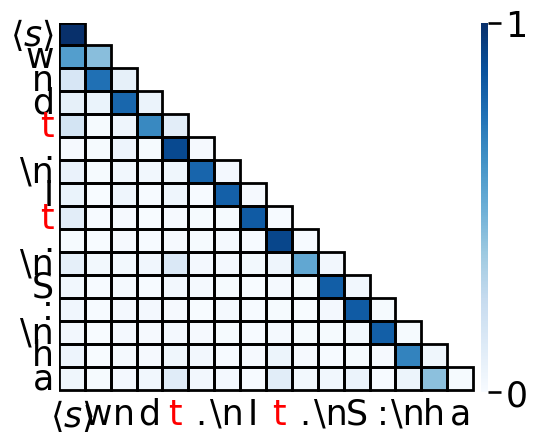

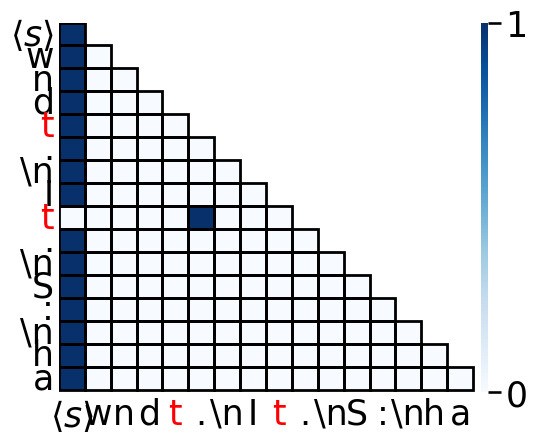

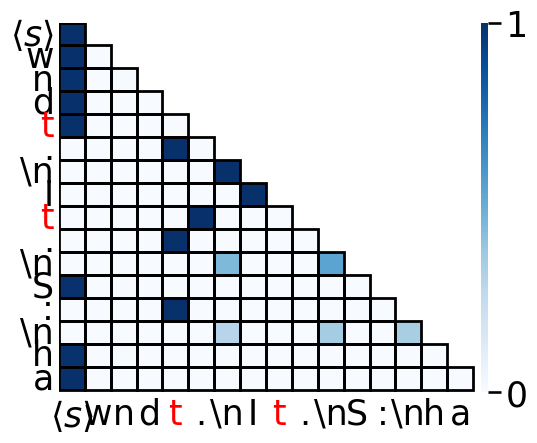

In [25]:
seq_indices = [1]
seq_len = 16
layer_idx = 0
head_idx = 0
for layer_idx in range(3):
    plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=[f'biette_attn_fig{layer_idx}.pdf'], fn=dir_name, red_trigger=True, use_grid=True)

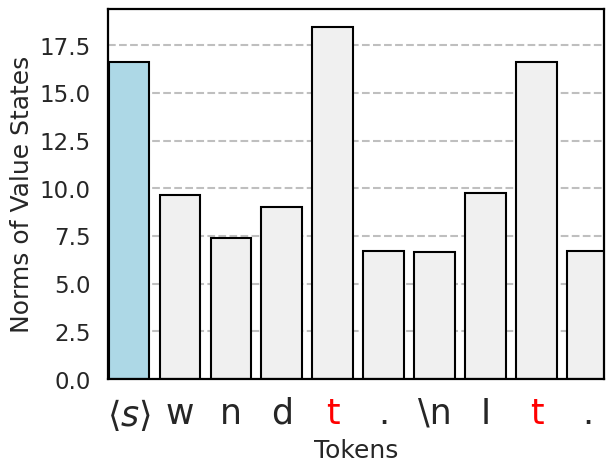

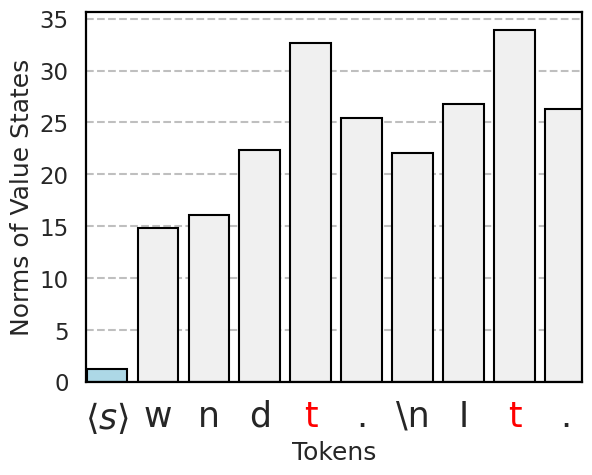

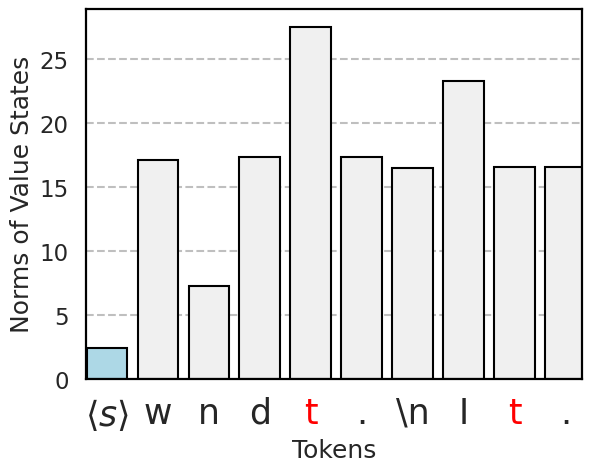

In [26]:
for layer_idx in range(3):
    idx = 1
    v_norm = model.layers[layer_idx].attention.wo(outputs_list[layer_idx]['value_states'][idx, 0, :10, :]).norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'$\langle s\rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Value States', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"biette_value_states_layer_{layer_idx}.pdf"), bbox_inches='tight')

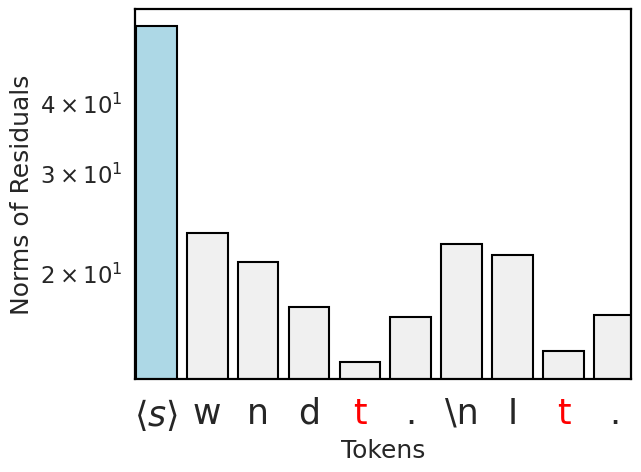

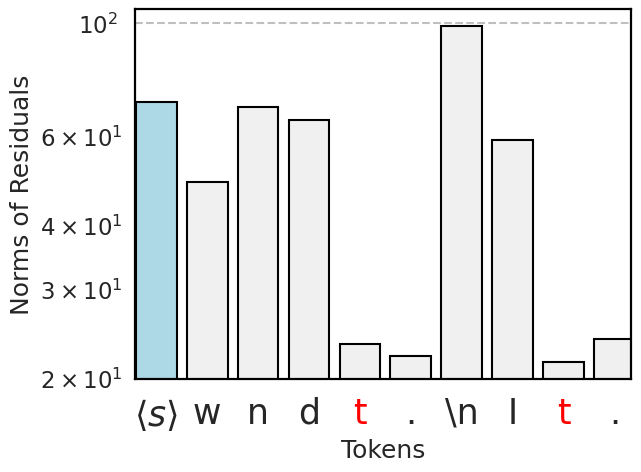

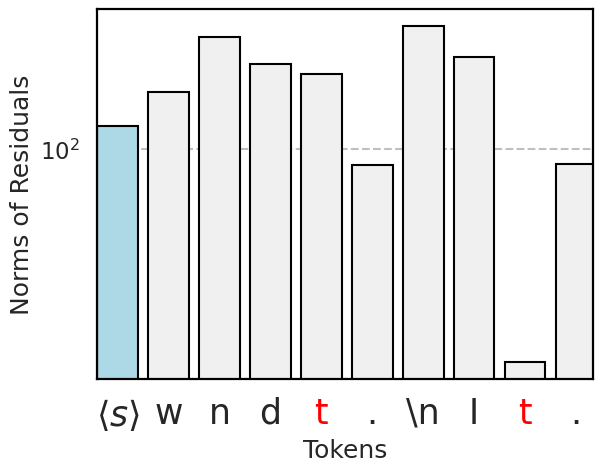

In [27]:
for layer_idx in range(3):
    idx = 1
    v_norm = model.layers[layer_idx].attention.wo(outputs_list[layer_idx]['output'][idx, :10, :]).norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'$\langle s \rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Residuals', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        ax.set_yscale('log')
        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"biette_norms_layer_{layer_idx}.pdf"), bbox_inches='tight')

## Bigram-backward

In [41]:
torch.cuda.set_device(6)
device = 'cuda:6'
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/final/dormant_markov"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=1, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.0003, use_simple_model=False, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True, with_optim=False)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
hook = forward_hook([], '')
pred, outputs_list = model.modified_forward_with_hook(x, hook)
# probs = get_oracle_predicts(x, ds)
# risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
# oracle_risk = get_risk(probs, probs, predict_in_logits=False, triggers_pos=triggers_pos)
# risk[1:3]

In [42]:
active_seq = np.array([65, 60,  1, 60, 52, 39, 59,  1, 59, 46,  1, 46, 46, 58, 39, 58, 39, 60, 43, 60, 43, 60, 39, 52,  1, 52, 57,  1, 57])
dormant_seq = np.array([65, 17, 31, 47, 52, 47, 52, 45, 50, 63,  0, 21, 26, 53, 56, 61, 39, 61, 46, 47, 50, 53, 60, 63, 53, 39, 57, 46, 39])
seqs = torch.from_numpy(np.stack((dormant_seq, active_seq), axis=0)).cuda()
predicts_plot, outputs_list_plot = model.modified_forward_with_hook(seqs, hook)
# outputs_list_plot = move_device(outputs_list_plot)

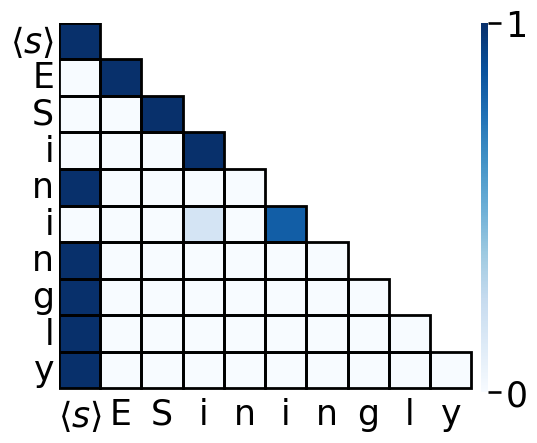

In [39]:
seq_indices = [0]
seq_len = 10
layer_idx = 0
head_idx = 0
plot_attn_weights(outputs_list_plot, seqs, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=[f'BS_attn.pdf'], fn=dir_name, red_trigger=True, use_grid=True)
# seq_len = 16
# layer_idx = 0
# head_idx = 0
# for layer_idx in range(2):
#     plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=[f'dmarkov_attn_fig{layer_idx}.pdf'], fn=dir_name, red_trigger=True, )

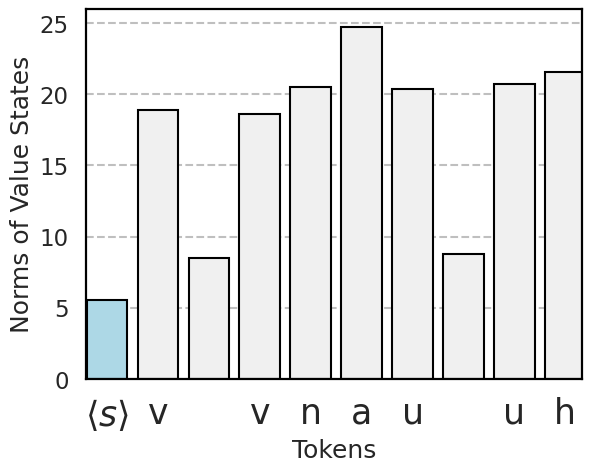

In [44]:
for layer_idx in range(1):
    idx = 1
    v_norm = model.layers[layer_idx].attention.wo(outputs_list_plot[layer_idx]['value_states'][idx, 0, :10, :]).norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(seqs.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'$\langle s \rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Value States', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"BS_value.pdf"), bbox_inches='tight')

KeyError: 'output'

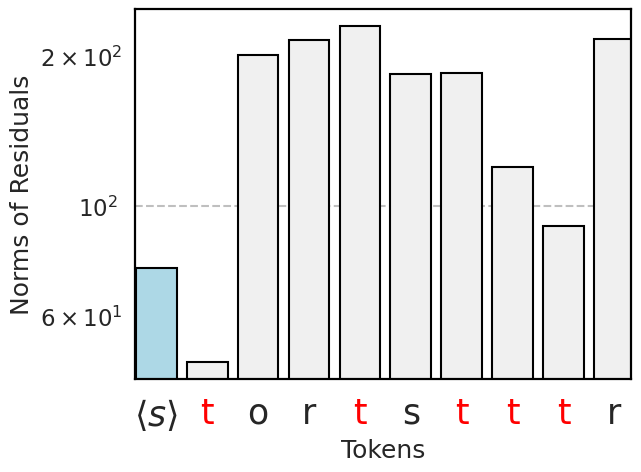

In [104]:
for layer_idx in range(3):
    idx = 1
    v_norm = outputs_list[layer_idx]['output'][idx, :10, :].norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'$\langle s \rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Residuals', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        ax.set_yscale('log')
        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"dmarkov_norms_layer_{layer_idx}.pdf"), bbox_inches='tight')

## Attention maps, value states, and norms of simplified model

In [45]:
# run_path_server = "~/gens/pre-iclr/dynamics/bbm_k3_bos1"
run_path_server = "~/gens/pre-iclr/dynamics/SimpleModel"
no_attn = ( )

model_loader = ModelLoader(run_path_local=None, run_path_server=run_path_server, bos_num=1, train_steps=10000, delim=0, n_layers=1, n_heads=1, no_attn_norm=(), no_ffn_norm=(), no_attn=no_attn, no_ffn=(), linear_ffn=(), lr=0.03, use_simple_model=True, use_vo=True, use_read_out=False, seed=42, with_data=True, with_optim=True, data_path_local=None, data_path_server="~/data", device=device)
model_loader.change_steps(10000)
model, cfg, x, y, ds, optim = model_loader(with_data=True)
idxs_in_torch = torch.Tensor(ds.idxs).to(device)
triggers_pos = torch.isin(x, torch.Tensor(ds.idxs).to(device))
pred, outputs_list = model.modified_forward(x, triggers_pos)
probs = get_oracle_predicts(x, ds)
risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
risk[1:3]

(tensor(2.1298e-07, device='cuda:6', grad_fn=<MeanBackward0>),
 tensor(2.2299, device='cuda:6', grad_fn=<MeanBackward0>))

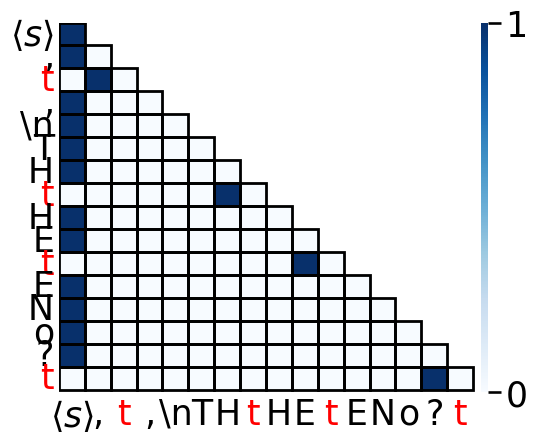

In [46]:
seq_indices = [0]
seq_len = 16
layer_idx = 0
head_idx = 0
for layer_idx in range(1):
    plot_attn_weights(outputs_list, x, ds, seq_indices, seq_len, layer_idx, head_idx, seq_start=0, keep_label=None, ticks_size=fontsize, titles=[], save_files_fn=[f'simple_attn_fig{layer_idx}.pdf'], fn=dir_name, red_trigger=True, use_simple=True, use_grid=True)

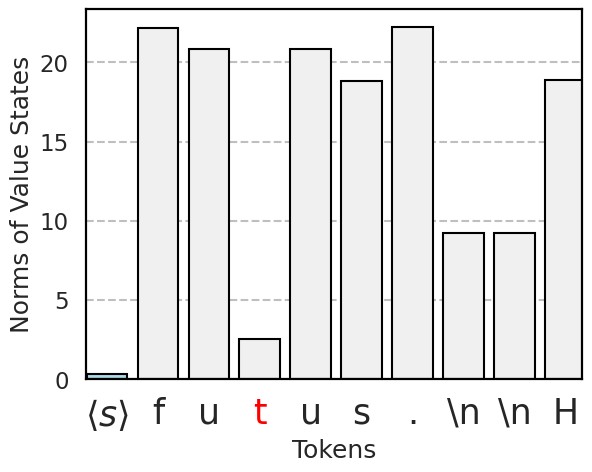

In [47]:
for layer_idx in range(1):
    idx = 1
    v_norm = outputs_list[layer_idx]['value_states'][idx, :10, :].norm(dim=-1).detach().cpu().numpy()
    text = ds.decode(x.detach().cpu().numpy()[idx, :])[:10]
    text[0] = r'$\langle s \rangle$'

    with sns.axes_style("whitegrid"):
        fontsize = 25
        fig, ax = plt.subplots()
        data = {'text': range(len(text)), 'v_norm': v_norm, 'group': [0]+[1]*(len(text)-1)}

        # Plot the bar plot with white facecolor and black edgecolor
        sns.barplot(x='text', y='v_norm', data=data, ax=ax, facecolor='#f0f0f0', edgecolor='black')

        bars = ax.patches
        bars[0].set_facecolor("#add8e6")
        # Set the style and context
        sns.set_context("talk")

        # Set x and y ticks and labels
        ax.set_xticks(range(len(text)))
        ax.set_xticklabels(text, fontsize=fontsize)
        # if layer_idx in [1, 2]:
        #     ax.set_yticks([0, 5, 10, 15, 20])
        #     ax.set_yticklabels([0, 5, 10, 15, 20], fontsize=fontsize)
        # else:
        #     ax.set_yticks([0, 10, 20, 30, 40])
        #     ax.set_yticklabels([0, 10, 20, 30, 40], fontsize=fontsize)

        # Set labels
        ax.set_xlabel('Tokens', fontsize=18)
        ax.set_ylabel('Norms of Value States', fontsize=18)

        # Set gridline properties: black color and solid lines
        # ax.grid(linestyle='-', color='black')
        ax.grid(False, axis='y')

        # Customize the spines to be solid, thin, black lines
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.6)  # You can adjust the linewidth as needed

        # Keep x-ticks non-rotated
        plt.grid(linestyle='--', color='grey', alpha=0.5, axis='y')
        plt.xticks(rotation=0)
        plt.xlim(-0.41, len(text) - 0.67)
        

        # Change the color of the x-tick label that equals 't' to red
        xticks = ax.get_xticklabels()
        for xt in xticks:
            if xt.get_text() == 't':
                xt.set_color('red')

        # Save the figure as a PDF
        plt.savefig(os.path.join(dir_name, f"simple_value_states_layer_{layer_idx}.pdf"), bbox_inches='tight')

In [48]:
outputs_norms = {}
logits = {}
value_states_norm = {}
minimal_layer_idx = 0
copy_layer_idx = 1 if cfg.simple_model_args.n_layers==3 else 0
with torch.no_grad():
    for step in tqdm(torch.arange(0, 1000, 5).tolist()+torch.arange(1000, 10001, 200).tolist()):
        model_loader.change_steps(step)
        model, cfg, optim = model_loader(with_data=False)
        _, outputs_list = model.modified_forward(x, triggers_pos)
        outputs_norms[step] = outputs_list[minimal_layer_idx]['output'][0, 0, :].norm(dim=-1).item()
        logits[step] = outputs_list[copy_layer_idx]['attn_logits'][0, 1, 0].item()
        value_states_norm[step] = outputs_list[copy_layer_idx]['value_states'][0, 0, :].norm().item()


  0%|          | 0/246 [00:00<?, ?it/s]

100%|██████████| 246/246 [00:15<00:00, 15.47it/s]


In [50]:
unique_x = torch.unique(x)
outputs_norms = {}
logits = {}
value_states_norm = {}
icl_risks = {}
markov_risks = {}
attns_on_bos = {}
bos_logit_differece_list = {}
non_bos_logits_list = {}
test_logits = {}

with torch.no_grad():
    for step in tqdm(torch.arange(0, 1000, 5).tolist()+torch.arange(1000, 10001, 200).tolist()):
        model_loader.change_steps(step)
        model, _, optim = model_loader(with_data=False, state_name="attn_state" if step >= 100000 else None)
        pred, outputs_list = model.modified_forward(x, triggers_pos)
        outputs_norms[step] = outputs_list[0]['output'][0, 0, :].norm(dim=-1).item()
        logits[step] = summarise_attns(outputs_list[0]['attn_logits'][:, :, 0], x, unique_x)
        # test_logits[step] = summarise_attns(outputs_list[0]['attn_logits'][:, :, 0] - outputs_list[0]['attn_logits'][:, :, 1], x, unique_x)
        # non_bos_logits, bos_logit_differece = summarise_logits_difference(outputs_list[0]['attn_logits'][:, 0, ...], x, unique_x)
        # bos_logit_differece_list[step] = bos_logit_differece
        # non_bos_logits_list[step] = non_bos_logits
        attns_on_bos[step] = outputs_list[0]['attn_weights'][:, :, 0][~triggers_pos].mean().detach().item()
        value_states_norm[step] = outputs_list[0]['value_states'][0, 0, :].norm().item()
        risk = get_risk(probs, pred, predict_in_logits=True, triggers_pos=triggers_pos)
        icl_risks[step] = risk[1].item()
        markov_risks[step] = risk[2].item()
logit_summary = torch.stack(list(logits.values()), dim=0)
# bos_logit_differece_summary = torch.stack(list(bos_logit_differece_list.values()), dim=0)
# non_bos_logits_summary = torch.stack(list(non_bos_logits_list.values()), dim=0)
# test_logits_summary = torch.stack(list(test_logits.values()), dim=0)

  0%|          | 0/246 [00:00<?, ?it/s]

100%|██████████| 246/246 [00:15<00:00, 15.57it/s]


In [68]:
logit_summary.shape, len(icl_risks.keys())

(torch.Size([246, 64]), 246)

In [69]:
mask = logit_summary[:, :].mean(dim=0).cpu() > 2
mask[-1] = False

In [53]:
stop_step = -1
fontsize = 25
step_size = 5
x_keys = list(icl_risks.keys())[:stop_step][::step_size]
x_keys_2 = list(icl_risks.keys())[::step_size]

icl_y = np.array(list(icl_risks.values()))[:stop_step][::step_size]
icl_y = icl_y / icl_y.max()
markov_y = np.array(list(markov_risks.values()))[:stop_step][::step_size]
markov_y = markov_y - oracle_risk[2].item()
markov_y = markov_y / markov_y.max()
value_states_y = np.array(list(value_states_norm.values()))[:stop_step][::step_size]
value_states_y = value_states_y / value_states_y.max()
outputs_norms_y = np.array(list(outputs_norms.values()))[:stop_step][::step_size]
outputs_norms_y = outputs_norms_y / outputs_norms_y.max()
attns_on_bos_y = np.array(list(attns_on_bos.values()))[:stop_step][::step_size]
attns_on_bos_y = attns_on_bos_y / attns_on_bos_y.max()
logit_y = logit_summary[:, mask][::step_size].cpu()
logit_y = logit_y / logit_y.mean(dim=-1).max()
logit_y_upper = logit_y.quantile(dim=1, q=0.9)
logit_y_lower = logit_y.quantile(dim=1, q=0.1)
logit_y = logit_y.mean(dim=1)

attns_on_bos_y_2 = np.array(list(attns_on_bos.values()))[::step_size]

value_states_y_2 = np.array(list(value_states_norm.values()))[::step_size]
value_states_y_2 = value_states_y_2 / value_states_y_2.max()

fig_2_start = stop_step//step_size-1
x_keys_2 = x_keys_2[fig_2_start:]
logit_y_1 = logit_y[:fig_2_start+1]
logit_y = logit_y[fig_2_start:]
logit_y_upper = logit_y_upper[fig_2_start:]
logit_y_lower = logit_y_lower[fig_2_start:]
value_states_y_2 = value_states_y_2[fig_2_start:]
attns_on_bos_y_2 = attns_on_bos_y_2[fig_2_start:]


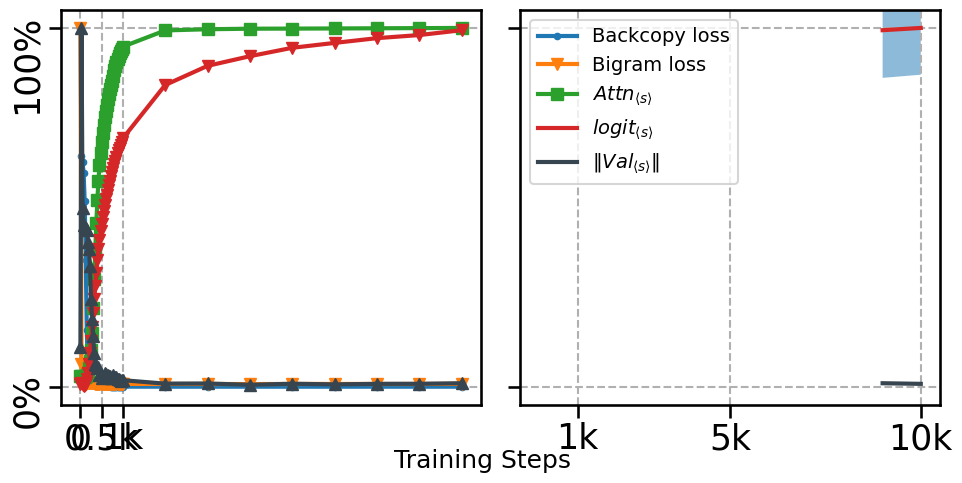

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()
for i in range(2):
    ax = axes[i]
    if i == 0:
        lw = 3
        ax.plot(x_keys, icl_y, label='Backcopy loss', marker='.', lw=lw)
        ax.plot(x_keys, markov_y, label='Bigram loss', marker='v', lw=lw)
        ax.plot(x_keys, attns_on_bos_y, label=r'$Attn_{<s>}$', marker='s', lw=lw)
        ax.plot(x_keys, logit_y_1, marker='v', label=r'$Logit_{\langle s\rangle}$', lw=lw)
        ax.plot(x_keys, value_states_y, marker='^', color='#36454F', lw=lw)
        ax.grid(linestyle='--')
        ax.set_yticks([0, 1])
        ax.set_yticklabels(['0%', '100%'], fontsize=fontsize, rotation=90)
        ax.set_xticks([0, 500, 1000])
        ax.set_xticklabels([0, "0.5k", '1k'], fontsize=fontsize)
    else:
        ax.plot(-1, 2, label='Backcopy loss', marker='.', lw=lw)
        ax.plot(-1, 2, label='Bigram loss', marker='v', lw=lw)
        ax.plot(-1, 2, label=r'$Attn_{\langle s\rangle}$', marker='s', lw=lw)
        ax.plot(x_keys_2, logit_y, label=r'$logit_{\langle s\rangle}$', lw=lw)
        ax.fill_between(x_keys_2, logit_y_lower, logit_y_upper, alpha=0.5)
        ax.plot(x_keys_2, value_states_y_2, color='#36454F', label=r'$\|Val_{\langle s \rangle}\|$', lw=lw)
        ax.set_yticks([0, 1])
        ax.set_ylim(-0.05, 1.05)
        ax.set_yticklabels(['', ''], fontsize=fontsize)
        # ax.set_xscale('log')
        ax.set_xticks([1000, 5000, 10000])
        ax.set_xticklabels(['1k', '5k', '10k'], fontsize=fontsize)
        ax.grid(linestyle='--')
fig.text(0.5, 0.03, 'Training Steps', ha='center', fontsize=18)
plt.tight_layout()
plt.legend(fontsize=14)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(dir_name, "simple_dynamics_combine.pdf"), bbox_inches='tight')

In [55]:
stop_step = 200
fontsize = 25
step_size = 5
x_keys = list(icl_risks.keys())[:stop_step][::step_size]
x_keys_2 = list(icl_risks.keys())[::step_size]

icl_y = np.array(list(icl_risks.values()))[:stop_step][::step_size]
icl_y = icl_y / icl_y.max()
markov_y = np.array(list(markov_risks.values()))[:stop_step][::step_size]
markov_y = markov_y - oracle_risk[2].item()
markov_y = markov_y / markov_y.max()
value_states_y = np.array(list(value_states_norm.values()))[:stop_step][::step_size]
value_states_y = value_states_y / value_states_y.max()
outputs_norms_y = np.array(list(outputs_norms.values()))[:stop_step][::step_size]
outputs_norms_y = outputs_norms_y / outputs_norms_y.max()
attns_on_bos_y = np.array(list(attns_on_bos.values()))[:stop_step][::step_size]
attns_on_bos_y = attns_on_bos_y / attns_on_bos_y.max()
logit_y = logit_summary[:, mask][::step_size].cpu()
logit_y = logit_y / logit_y.mean(dim=-1).max()
logit_y_upper = logit_y.quantile(dim=1, q=0.9)
logit_y_lower = logit_y.quantile(dim=1, q=0.1)
logit_y = logit_y.mean(dim=1)

attns_on_bos_y_2 = np.array(list(attns_on_bos.values()))[::step_size]

value_states_y_2 = np.array(list(value_states_norm.values()))[::step_size]
value_states_y_2 = value_states_y_2 / value_states_y_2.max()

fig_2_start = stop_step//step_size-1
x_keys_2 = x_keys_2[fig_2_start:]
logit_y_1 = logit_y[:fig_2_start+1]
logit_y = logit_y[fig_2_start:]
logit_y_upper = logit_y_upper[fig_2_start:]
logit_y_lower = logit_y_lower[fig_2_start:]
value_states_y_2 = value_states_y_2[fig_2_start:]
attns_on_bos_y_2 = attns_on_bos_y_2[fig_2_start:]


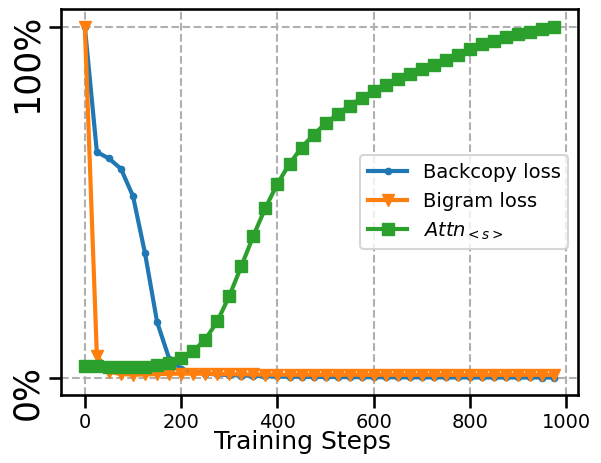

In [56]:
lw = 3
fig, ax = plt.subplots()

ax.plot(x_keys, icl_y, label='Backcopy loss', marker='.', lw=lw)
ax.plot(x_keys, markov_y, label='Bigram loss', marker='v', lw=lw)
ax.plot(x_keys, attns_on_bos_y, label=r'$Attn_{<s>}$', marker='s', lw=lw)
# ax.plot(x_keys, logit_y_1, marker='v', label=r'$Logit_{\langle s\rangle}$', lw=lw)
# ax.plot(x_keys, value_states_y, marker='^', color='#36454F', lw=lw)
ax.grid(linestyle='--')
ax.set_yticks([0, 1])
ax.set_yticklabels(['0%', '100%'], fontsize=fontsize, rotation=90)
# ax.set_xticks([0, 500, 1000])
# ax.set_xticklabels([0, "0.5k", '1k'], fontsize=fontsize)
fig.text(0.5, 0.03, 'Training Steps', ha='center', fontsize=18)
plt.tight_layout()
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(dir_name, "simple_dynamics.pdf"), bbox_inches='tight')

In [57]:
stop_step = -1
fontsize = 25
step_size = 5
x_keys = list(icl_risks.keys())[:stop_step][::step_size]
x_keys_2 = list(icl_risks.keys())[::step_size]

icl_y = np.array(list(icl_risks.values()))[:stop_step][::step_size]
icl_y = icl_y / icl_y.max()
markov_y = np.array(list(markov_risks.values()))[:stop_step][::step_size]
markov_y = markov_y - oracle_risk[2].item()
markov_y = markov_y / markov_y.max()
value_states_y = np.array(list(value_states_norm.values()))[:stop_step][::step_size]
value_states_y = value_states_y / value_states_y.max()
outputs_norms_y = np.array(list(outputs_norms.values()))[:stop_step][::step_size]
outputs_norms_y = outputs_norms_y / outputs_norms_y.max()
attns_on_bos_y = np.array(list(attns_on_bos.values()))[:stop_step][::step_size]
attns_on_bos_y = attns_on_bos_y / attns_on_bos_y.max()
logit_y = logit_summary[:, mask][::step_size].cpu()
logit_y = logit_y / logit_y.mean(dim=-1).max()
logit_y_upper = logit_y.quantile(dim=1, q=0.9)
logit_y_lower = logit_y.quantile(dim=1, q=0.1)
logit_y = logit_y.mean(dim=1)

attns_on_bos_y_2 = np.array(list(attns_on_bos.values()))[::step_size]

value_states_y_2 = np.array(list(value_states_norm.values()))[::step_size]
value_states_y_2 = value_states_y_2 / value_states_y_2.max()

fig_2_start = stop_step//step_size-1
x_keys_2 = x_keys_2[fig_2_start:]
logit_y_1 = logit_y[:fig_2_start+1]
logit_y = logit_y[fig_2_start:]
logit_y_upper = logit_y_upper[fig_2_start:]
logit_y_lower = logit_y_lower[fig_2_start:]
value_states_y_2 = value_states_y_2[fig_2_start:]
attns_on_bos_y_2 = attns_on_bos_y_2[fig_2_start:]


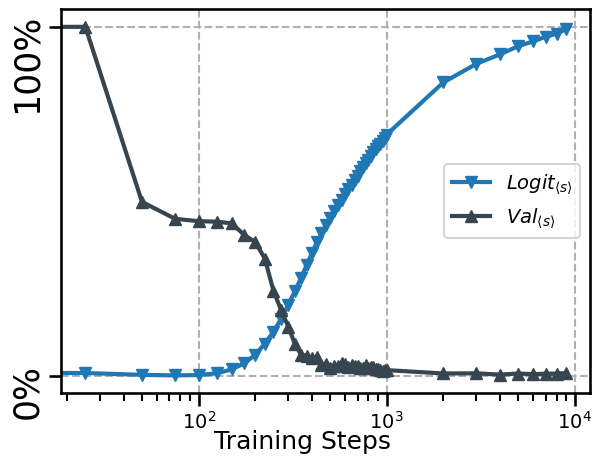

In [58]:
lw = 3
fig, ax = plt.subplots()

# ax.plot(x_keys, icl_y, label='Backcopy loss', marker='.', lw=lw)
# ax.plot(x_keys, markov_y, label='Bigram loss', marker='v', lw=lw)
# ax.plot(x_keys, attns_on_bos_y, label=r'$Attn_{<s>}$', marker='s', lw=lw)
ax.plot(x_keys, logit_y_1, marker='v', label=r'$Logit_{\langle s\rangle}$', lw=lw)
ax.plot(x_keys, value_states_y, marker='^', label=r'$Val_{\langle s\rangle}$', color='#36454F', lw=lw)
ax.grid(linestyle='--')
ax.set_yticks([0, 1])
ax.set_yticklabels(['0%', '100%'], fontsize=fontsize, rotation=90)
ax.set_xscale('log')
# ax.set_xticks([0, 500, 1000])
# ax.set_xticklabels([0, "0.5k", '1k'], fontsize=fontsize)
fig.text(0.5, 0.03, 'Training Steps', ha='center', fontsize=18)
plt.tight_layout()
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(dir_name, "simple_dynamics_logit.pdf"), bbox_inches='tight')

### remake the dynamics plot

In [74]:
fontsize = 25
step_size = 3
x_keys = np.array(list(icl_risks.keys()))
cutoff = 400
stop_step = np.where(x_keys > cutoff)[0].min()
ticksteps = [0, 200, 400, 1000, 5000, 10000]
ticklabels = ['0', '0.2k', "0.4k", '1k', '5k', '10k']
tickx = np.isin(x_keys, ticksteps)

x_keys_1 = np.array(list(icl_risks.keys()), dtype=float)
x_keys_1[stop_step:] = np.log(x_keys_1[stop_step:])
x_keys_1[stop_step:] = (x_keys_1[stop_step:]-x_keys_1[stop_step:].min()) * cutoff / (x_keys_1[stop_step:].max()-x_keys_1[stop_step:].min()) + cutoff + x_keys_1[stop_step:].min()
x_keys_2 = list(icl_risks.keys())[:stop_step][::step_size]


icl_y = np.array(list(icl_risks.values()))
icl_y = icl_y / icl_y.max()
markov_y = np.array(list(markov_risks.values()))
markov_y = markov_y - oracle_risk[2].item()
markov_y = markov_y / markov_y.max()
value_states_y = np.array(list(value_states_norm.values()))
value_states_y = value_states_y / value_states_y.max()
outputs_norms_y = np.array(list(outputs_norms.values()))
outputs_norms_y = outputs_norms_y / outputs_norms_y.max()
attns_on_bos_y = np.array(list(attns_on_bos.values()))
attns_on_bos_y = attns_on_bos_y / attns_on_bos_y.max()
logit_y = logit_summary[:, mask].cpu()
logit_y = logit_y / logit_y.mean(dim=-1).max()
logit_y_upper = logit_y.quantile(dim=1, q=0.9)
logit_y_lower = logit_y.quantile(dim=1, q=0.1)
logit_y = logit_y.mean(dim=1)

icl_y_1, markov_y_1, value_states_y_1, outputs_norms_y_1, attns_on_bos_y_1 = icl_y, markov_y, value_states_y, outputs_norms_y, attns_on_bos_y
logit_y_1, logit_y_upper_1, logit_y_lower_1 = logit_y, logit_y_upper, logit_y_lower
icl_y_2, markov_y_2, value_states_y_2, outputs_norms_y_2, attns_on_bos_y_2 = icl_y[:stop_step][::step_size], markov_y[:stop_step][::step_size], value_states_y[:stop_step][::step_size], outputs_norms_y[:stop_step][::step_size], attns_on_bos_y[:stop_step][::step_size]
logit_y_2, logit_y_upper_2, logit_y_lower_2 = logit_y[:stop_step][::step_size], logit_y_upper[:stop_step][::step_size], logit_y_lower[:stop_step][::step_size]

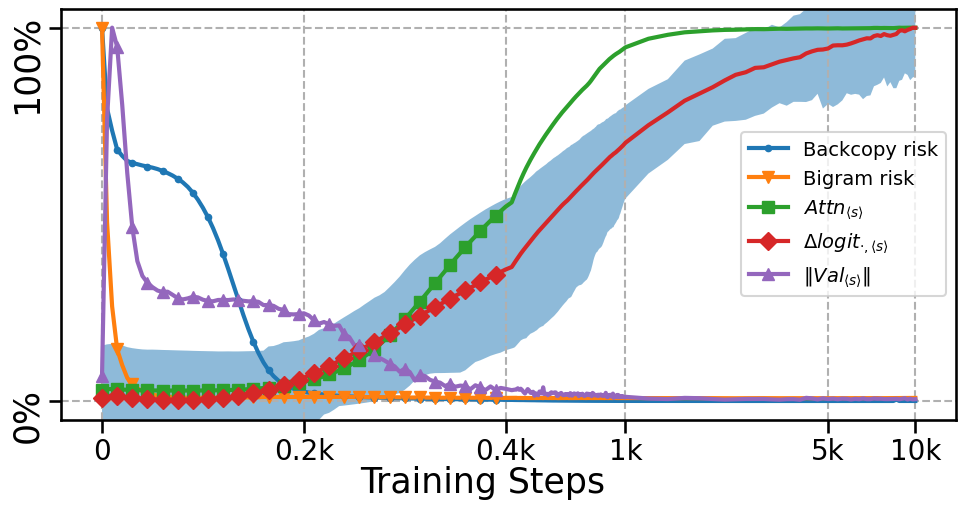

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

lw = 3
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.plot(x_keys_1, icl_y_1, lw=lw, color=colors[0])
ax.plot(x_keys_1, markov_y_1, lw=lw, color=colors[1])
ax.plot(x_keys_1, attns_on_bos_y_1, lw=lw, color=colors[2])
ax.plot(x_keys_1, logit_y_1, lw=lw, color=colors[3])
ax.fill_between(x_keys_1, logit_y_lower_1, logit_y_upper_1, alpha=0.5)
ax.plot(x_keys_1, value_states_y_1, lw=lw, color=colors[4])
ax.grid(linestyle='--')
ax.plot(x_keys_2, icl_y_2, marker='.', lw=0, color=colors[0])
ax.plot(x_keys_2, markov_y_2, marker='v', lw=0, color=colors[1])
ax.plot(x_keys_2, attns_on_bos_y_2, marker='s', lw=0, color=colors[2])
ax.plot(x_keys_2, logit_y_2, marker='D', lw=0, color=colors[3])
ax.plot(x_keys_2, value_states_y_2, marker='^', lw=0, color=colors[4])
# add legends
ax.plot(0, -1, marker='.', label='Backcopy risk', lw=lw, color=colors[0])
ax.plot(0, -1, marker='v', label='Bigram risk', lw=lw, color=colors[1])
ax.plot(0, -1, marker='s', label=r'$Attn_{\langle s\rangle}$', lw=lw, color=colors[2])
ax.plot(0, -1, marker='D', label=r'$\Delta logit_{\cdot,\langle s\rangle}$', lw=lw, color=colors[3])
ax.plot(0, -1, marker='^', label=r'$\|Val_{\langle s \rangle}\|$', lw=lw, color=colors[4])

ax.set_yticks([0, 1])
ax.set_ylim(-0.05, 1.05)
# ax.vlines(4006, -0.05, 1.15, linestyle='--', color='black', lw=4)
# ax.vlines(200, -0.05, 1.15, linestyle='--', color='black', lw=2)
ax.set_yticklabels(['0%', '100%'], fontsize=fontsize, rotation=90)

ax.set_xticks(x_keys_1[tickx])
ax.set_xticklabels(ticklabels, fontsize=12)
ax.grid(linestyle='--')
for line in ax.get_xgridlines():
    if np.abs(line.get_xdata()[0] - 1000) < 10:  # Check if the line is at x=1000
        line.set_visible(False)  # Hide the line
fig.text(0.5, -0.02, 'Training Steps', ha='center', fontsize=fontsize)
plt.tight_layout()
# plt.legend(fontsize=12)
plt.legend(fontsize=14, )
# plt.legend(fontsize=14, loc='center right', bbox_to_anchor=(0.75, 0.65))
plt.xticks(fontsize=20)
plt.yticks(fontsize=fontsize)
plt.savefig(os.path.join(dir_name, "simple_dynamics_combine.pdf"), bbox_inches='tight')